In [4]:
import os
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from scipy.stats import gaussian_kde
import math
import matplotlib.pyplot as plt

In [5]:
# Funciones auxiliares
def synthetic_profile(dt=1, dis_curr=-0.5, charg_curr=0.5, lower_capacity=-2.5, upper_capacity=2.5, N=1000):
    # create a capacity profile to simulate a synthetic degradation profile
    capacity_profile = []  # List to store the synthetic capacity profile

    dis_cap = dis_curr * dt / 3600 # capacity step in Ah
    discharge_repetitions = int(lower_capacity / dis_cap)  # Number of repetitions for discharge steps

    charg_cap = charg_curr * dt / 3600 # capacity step in Ah
    charge_repetitions = int(upper_capacity / charg_cap)  # Number of repetitions for discharge steps
     
    for _ in range(N):
        # Fill the capacity profile with discharge and charge steps
        capacity_profile.extend([dis_cap] * discharge_repetitions)  # Fill with zeros for discharge steps    
        capacity_profile.extend([charg_cap] * charge_repetitions)  # Fill with zeros for discharge steps

    return capacity_profile

def fill_with_nan(lst, desired_length):
    # Calculate how many NaN values need to be added
    nan_count = desired_length - len(lst)
    
    # Add NaN values to the list if necessary
    if nan_count > 0:
        lst.extend([math.nan] * nan_count)
    
    return lst

In [6]:
class BatteryModel:

    def __init__(self, Qmax=4.850, degradation_percentage=0.8, life_cycles=650,ds_SR = 100, degradation_data=None):
        
        self.parameters = {
            "Qmax": Qmax,  # Carga nominal (Ah)
            "degradation_percentage": degradation_percentage,  # Por ejemplo, 80% de degradación
            "life_cycles": life_cycles,  # Por ejemplo, 1000 ciclos de vida
            "SR": ds_SR,  # Por ejemplo, 1000 ciclos de vida
            "degradation_data": degradation_data if degradation_data else {
                "100-0":        [1.00000],
                "100-25":       [0.78750],
                "75-0":         [1.12525],
                "100-50":       [0.43750],
                "75-25":        [0.68750],
                "50-0":         [1.03125],
                "100-75":       [0.40625],
                "75-50":        [0.29700],
                "62.5-37.5":    [0.28125],
                "50-25":        [0.62500],
                "25-0":         [1.00000],
            },
        }
        self.memoria_soc = []  # Inicialización de memoria SOC vacía
        self.setup_knn()  # Configura el modelo k-NN
        self.set_kde()
        self.set_std_cycles()

    def setup_knn(self):
        # Preparar los datos para el modelo k-NN
        X = []
        y = []

        for sr, factors in self.parameters["degradation_data"].items():
            sr_range = [float(x) for x in sr.split("-")]
            sr_numeric = sr_range[0] - sr_range[1]  # SR
            asr_numeric = sum(sr_range) / 2  # ASR
            for std_degradation_percentage, factor in zip([0.8], factors):
                X.append([asr_numeric, sr_numeric, std_degradation_percentage])
                y.append(factor)

        # Convertir a numpy arrays
        X = np.array(X)
        y = np.array(y)

        # Entrenar el modelo k-NN
        self.knn = KNeighborsRegressor(n_neighbors=3, weights="distance")
        self.knn.fit(X, y)  # Entrenar el modelo k-NN

        print("modelo de celda seteado. Tabla de degradación: ",self.parameters["degradation_data"])

    def set_kde(self):
            path = "C:/Users/Bruno/OneDrive - Universidad de Chile/BGMG/CASE/git_repositories/degradation_model/uncertainty_characterization/eta_values_sorted.csv"
            eta_values = pd.read_csv(path,delimiter=',',header=None)
            eta_values = eta_values.values.flatten()
            self.kde = gaussian_kde(eta_values)
            print("KDE has been setted")
            # return(kde)

    def set_std_cycles(self):
            SR_0 = 100 # soc range de un ciclo equivalente 
            SR = self.parameters["SR"] # soc range de los subciclos del dataset
            eq_cycle = self.parameters["life_cycles"]*(SR/SR_0)

            eta_0 = self.parameters["degradation_percentage"]**(1/eq_cycle)
            eq_cycle08 = 1/self.log_a(0.8,eta_0)

            self.parameters["life_cycles"] = eq_cycle08
            self.parameters["degradation_percentage"] = 0.8
            self.parameters["SR"] = 100

            print("Life cycle has been setted")

    def temp_factor(self, temp):
        # definimos los coeficientes ya fiteados
        coef = np.array([-1.25736777e-11,  4.79001576e-10,  5.01975901e-08,  5.04209738e-07,
                -3.61735311e-04,  1.12614410e-02,  1.02131291e+00])
        # creamos la funcion generadora de factores por temperatura
        polynomial = np.poly1d(coef)
        # Calculamos el factor ponderador por temperatura
        factor = np.clip(polynomial(temp),0,1)
        return factor
    
    def log_a(self,a,x):
        y = np.log(x)/np.log(a)
        return y
    
    def get_factor(self, soc, temp):
            # Obtenermos el SSR y el ASSR
            ssr = max(soc) - min(soc)
            assr = np.mean(soc)

            # Obtenemos el factor para ponderar los ciclos
            knn_factor = self.knn.predict(
                np.array([[assr, ssr, self.parameters["degradation_percentage"]]])
            )

            # definimos los ciclos del KNN
            cycles_0 = self.parameters["life_cycles"]
            cycles_k = knn_factor * cycles_0

            # definimos los ciclos en función de la temperatura
            t_factor = self.temp_factor(temp)
            cycles_k_ = cycles_k * t_factor

            # definimos el eta con incertidumbre
            noise = self.kde.resample(1)[0][0] - 0.999161393145505 
            etak = 0.8**(1/cycles_k_) + noise 
            etak = np.clip(etak,0,1) # definimos limites porque el ruido puede generar valores demasiados extremos que no son reales
            return etak

# Definimos el perfil sintético de la aplicación

In [15]:
# Initialize the BatteryModel
degradated_batt = BatteryModel(Qmax=4.753,life_cycles=500, degradation_percentage=0.8) 

# Inner loop to iterate through multiple runs within each simulation (N defines the number of runs)
N = 3
i = 1

eq_cycle_count = 0  # Counter for equivalent cycles simulated
total_soh_values = pd.DataFrame()  # DataFrame to store SOH (State of Health) values for each run

# define the synthetic profile for the simulation
cap_profile = synthetic_profile(dt=1, dis_curr=-0.5, charg_curr=0.5, lower_capacity=-2.5, upper_capacity=2.5, N=1000)

while i <= N:
    current_Q = degradated_batt.parameters["Qmax"]*0.8  # Initial maximum capacity of the battery
    Q_values = [current_Q]  # List to store capacity values over time

    # Variables for the equivalent cycle calculation method
    dsoc = 0  # Change in SoC (State of Charge)
    soc_acc = 0  # Accumulated SoC change
    soc_inst_eqcycle = 1 * 100  # Initial SoC in percentage
    soc_counting_eqcycle = [soc_inst_eqcycle]  # List to track SoC changes
    eqcycle_SoH_values = []  # List to store SOH values for equivalent cycles

    # Iterate through all delta capacity values (dC_w10_standford_values2)
    for dc in cap_profile:
        dsoc = dc * 100 / current_Q  # Calculate change in SoC based on delta capacity
        soc_inst_eqcycle += dsoc  # Update the instantaneous SoC

        # Ensure SoC stays within valid bounds (0% to 100%)
        if soc_inst_eqcycle >= 100:
            soc_inst_eqcycle = 100
        elif soc_inst_eqcycle < 0:
            soc_inst_eqcycle = 0

        # Implementation of the equivalent cycle method
        if dsoc < 0:  # Only consider discharging events
            soc_acc += dsoc  # Accumulate SoC changes
            soc_counting_eqcycle.append(soc_inst_eqcycle)  # Track SoC changes

        # Check if an equivalent cycle is completed
        if -100 >= soc_acc:
            eta_k_eqcycle = degradated_batt.get_factor(soc_counting_eqcycle, 25)  # Get degradation factor
            current_Q *= eta_k_eqcycle[0]  # Update the current capacity based on degradation
            soc_acc = 0  # Reset accumulated SoC
            soc_counting_eqcycle = []  # Reset SoC tracking
            Q_values.append(current_Q)  # Append the updated capacity
            eq_cycle_count += 1  # Increment the equivalent cycle count

    Q_values = fill_with_nan(Q_values, 2000)
    Q_values = np.array(Q_values)
    SOH_values = Q_values / degradated_batt.parameters["Qmax"]  # Calculate SOH as a fraction of the initial capacity

    total_soh_values[i] = SOH_values  # Store SOH values for the current run
    i += 1

# Save the SOH values to a CSV file
filename = "SOH_values.csv"
print(filename)
# total_soh_values.to_csv(filename, index=False)

modelo de celda seteado. Tabla de degradación:  {'100-0': [1.0], '100-25': [0.7875], '75-0': [1.12525], '100-50': [0.4375], '75-25': [0.6875], '50-0': [1.03125], '100-75': [0.40625], '75-50': [0.297], '62.5-37.5': [0.28125], '50-25': [0.625], '25-0': [1.0]}
KDE has been setted
Life cycle has been setted


KeyboardInterrupt: 

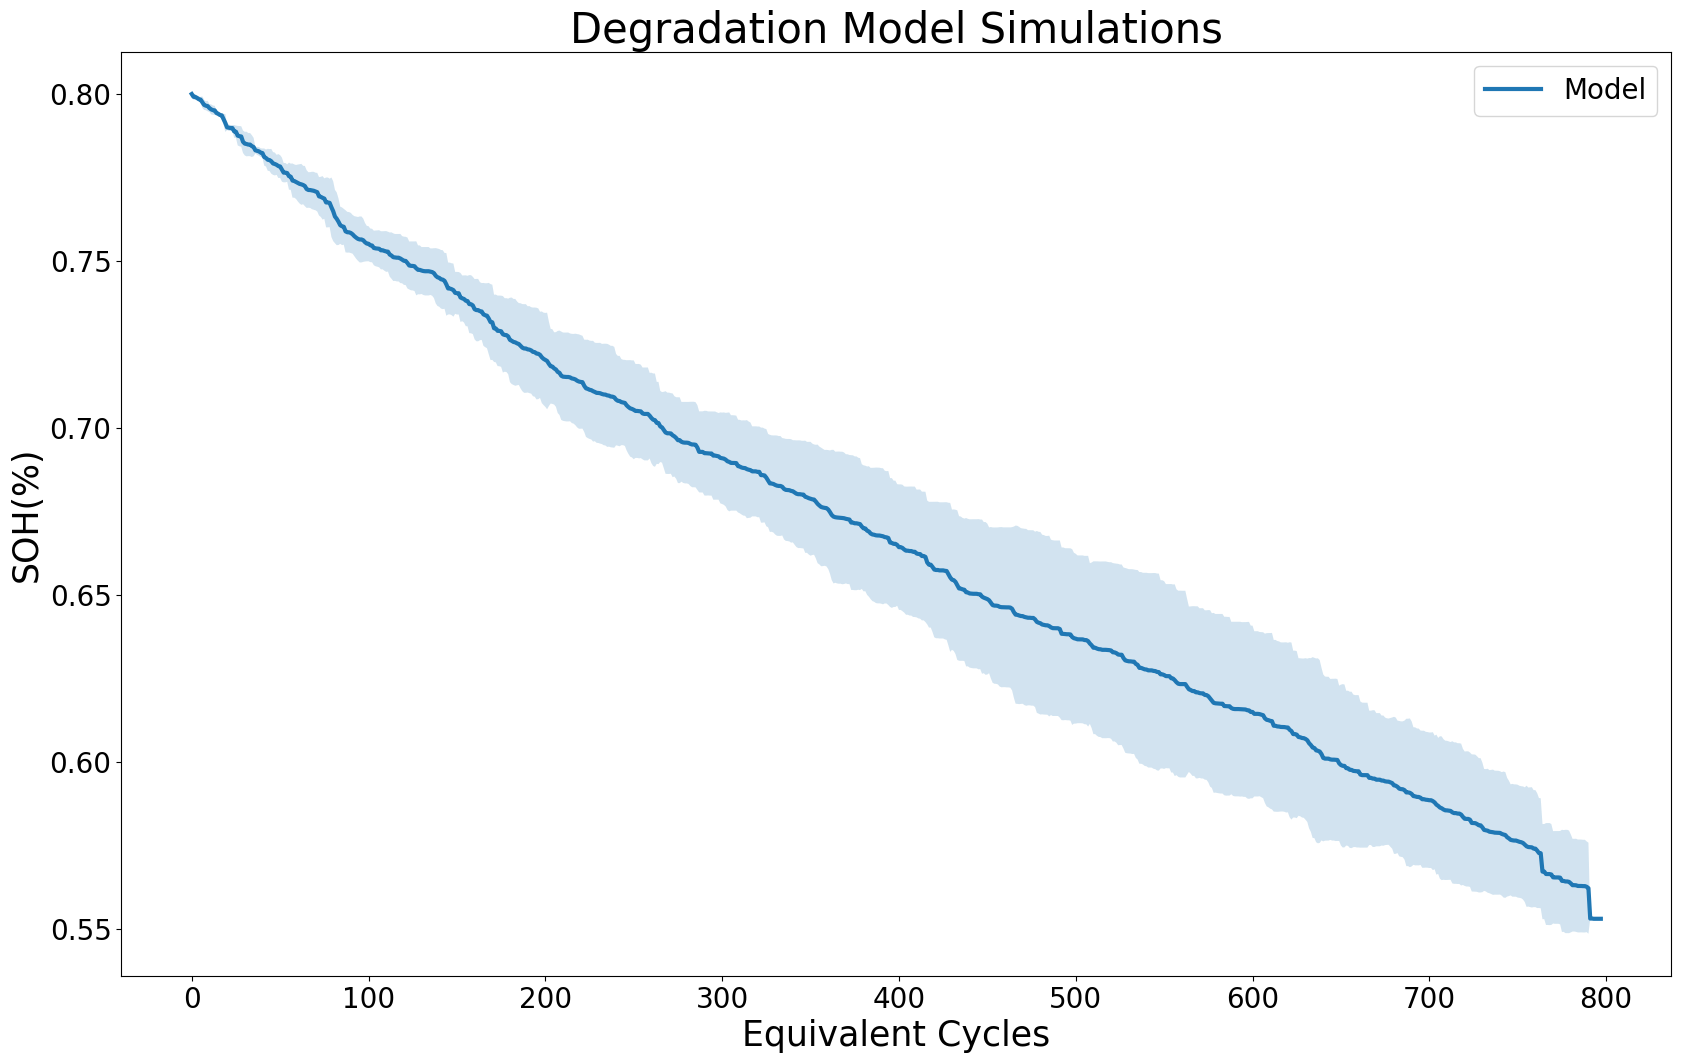

In [ ]:
# Get the mean and standard deviation of the SOH values
SOH_df = total_soh_values.iloc[:, :N]  # Select only the columns from 1 to N (number of simulations)
SOH_df['mean'] = SOH_df.mean(axis=1)
SOH_df['std'] = SOH_df.std(axis=1)

axis = np.arange(len(SOH_df['std']))

# Plot the simulations results
plt.figure(figsize=(20, 12))
plt.plot(SOH_df['mean'], label='Model', linewidth=3)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.fill_between(axis, SOH_df['mean'] - 1.5 * SOH_df['std'], SOH_df['mean'] + 1.5 * SOH_df['std'], alpha=0.2)

plt.title("Degradation Model Simulations", fontsize=30)
plt.xlabel("Equivalent Cycles", fontsize=25)
plt.ylabel("SOH(%)", fontsize=25)
plt.legend(fontsize=20)
plt.show()

# export the figure to a png file
# plt.savefig("simulaciones_degradacion_stanford.png", dpi=300, bbox_inches='tight')
# plt.close()  # Ensure the plot is closed after saving to avoid issues with overlapping plots in subsequent cells

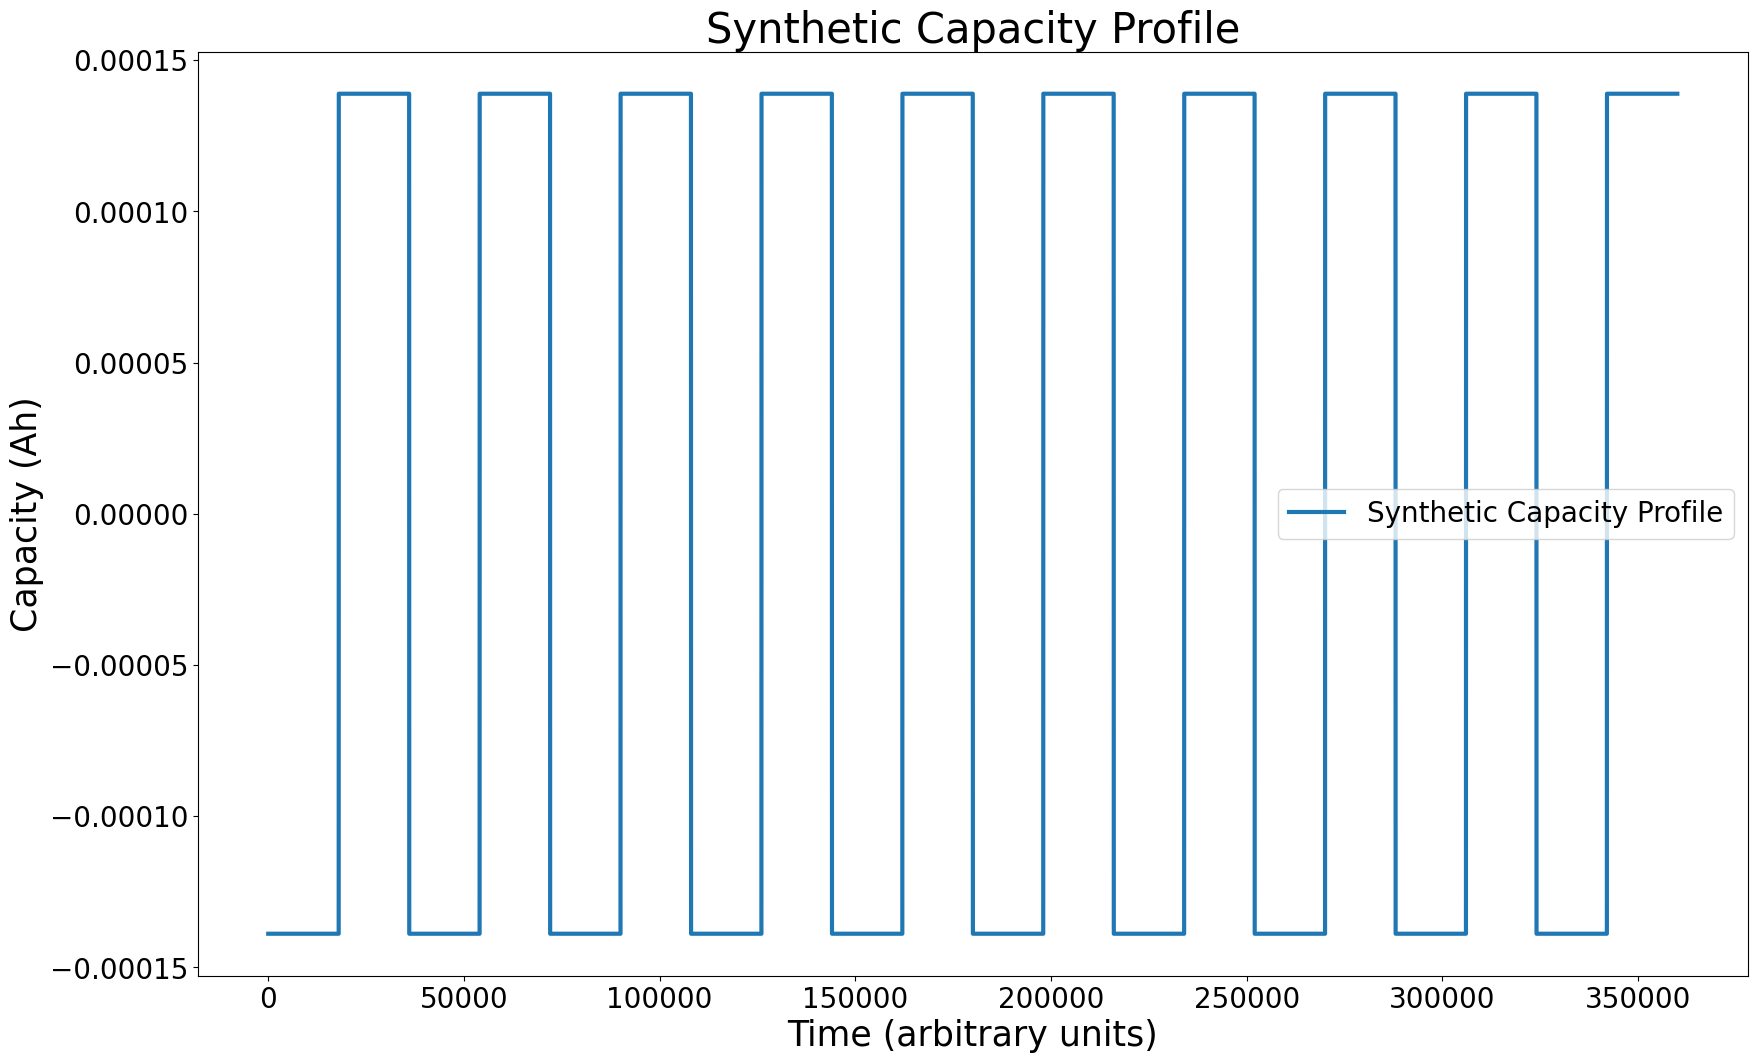

In [ ]:
cap_profile = synthetic_profile(dt=1, dis_curr=-0.5, charg_curr=0.5, lower_capacity=-2.5, upper_capacity=2.5, N=10)

# plot cap_profile
plt.figure(figsize=(20, 12))
plt.plot(cap_profile, label='Synthetic Capacity Profile', linewidth=3)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title("Synthetic Capacity Profile", fontsize=30)
plt.xlabel("Time (arbitrary units)", fontsize=25)
plt.ylabel("Capacity (Ah)", fontsize=25)
plt.legend(fontsize=20)
plt.show()

## Creamos la función para obtener el valor económico de una batería

In [7]:
def valorización(SOH_actual_prop, cap_0_prop, min_cap_app, valor_ideal, prop_cycles, ideal_cycles):
    """
    Calculate the current value of a battery based on its SOH and ideal value.
    
    Parameters:
    - SOH_actual: Current State of Health of the battery (as a percentage).
    - valor_ideal: Ideal value of the battery when it is new.
    
    Returns:
    - Current value of the battery.
    """

    min_SOH = min_cap_app/cap_0_prop # calculate minimum SOH for the proposed battery
    deg_factor = (1 - SOH_actual_prop) / (1 - max([0.6,min_SOH]))  # Calculate the degradation factor
    
    cycle_factor = prop_cycles/ideal_cycles
    
    valor_prop = valor_ideal * deg_factor * cycle_factor # compute the economic value of the proposed battery

    return valor_prop

def total_cycle(battery_model,initial_SOH,terminal_SOH,
                cap_profile,profile_amb_temp,initial_SOC,
                MC_runs=10):
    """
    Calculate the total amount of equivalent cycles a battery can perform of a certain usage profile

    Parameters:
    - SOH_actual: Current State of Health of the battery (as a percentage).
    - valor_ideal: Ideal value of the battery when it is new.

    Returns:
    - Current value of the battery.
    """

    total_soh_values = pd.DataFrame()  # DataFrame to store SOH (State of Health) values for each run
    total_eqcycle_values = np.array([])  # Numpy array to store equivalent cycle counts for each run
    soh_columns = [] # keep each run here first
    max_len = 0 # longest Q_values we have seen so far

    for i in range(MC_runs):

        eq_cycle_count = 0  # Counter for equivalent cycles simulated

        current_Q = battery_model.parameters["Qmax"] * initial_SOH  # Initial maximum capacity of the battery
        Q_values = [current_Q]  # List to store capacity values over time

        # Variables for the equivalent cycle calculation method
        dsoc = 0  # Change in SoC (State of Charge)
        soc_acc = 0  # Accumulated SoC change
        soc_inst_eqcycle = 1 * initial_SOC  # Initial SoC in percentage
        soc_counting_eqcycle = [soc_inst_eqcycle]  # List to track SoC changes

        # Iterate through all delta capacity values (dC_w10_standford_values2)
        for dc in cap_profile:
            dsoc = dc * 100 / current_Q  # Calculate change in SoC based on delta capacity
            soc_inst_eqcycle += dsoc  # Update the instantaneous SoC

            # Ensure SoC stays within valid bounds (0% to 100%)
            if soc_inst_eqcycle >= 100:
                soc_inst_eqcycle = 100
            elif soc_inst_eqcycle < 0:
                soc_inst_eqcycle = 0

            # Implementation of the equivalent cycle method
            if dsoc < 0:  # Only consider discharging events
                soc_acc += dsoc  # Accumulate SoC changes
                soc_counting_eqcycle.append(soc_inst_eqcycle)  # Track SoC changes

            # Check if an equivalent cycle is completed
            if -100 >= soc_acc:
                eta_k_eqcycle = battery_model.get_factor(soc_counting_eqcycle, profile_amb_temp)  # Get degradation factor
                current_Q *= eta_k_eqcycle[0]  # Update the current capacity based on degradation
                current_soh = current_Q / battery_model.parameters["Qmax"]
                soc_acc = 0  # Reset accumulated SoC
                soc_counting_eqcycle = []  # Reset SoC tracking
                Q_values.append(current_Q)  # Append the updated capacity
                eq_cycle_count += 1  # Increment the equivalent cycle count

                print(f'Run: {i + 1} Cycle: {eq_cycle_count} Current SOH: {current_soh}', end='\r')

                # Break the loop if the terminal SOH is reached
                if current_soh < terminal_SOH:
                    Q_values = np.array(Q_values)
                    # total_soh_values[i] = Q_values  # Store SOH values for the current run
                    total_eqcycle_values = np.append(total_eqcycle_values, eq_cycle_count)  # Store equivalent cycle count for the current run

                    max_len = max(max_len, len(Q_values))   # remember the tallest column
                    soh_columns.append(Q_values)            # keep raw list for now
                    print("Run", i + 1, "completed with SOH:", current_soh, "and equivalent cycles:", eq_cycle_count)
                    break

    # pad every run up to max_len
    soh_columns_padded = [
        np.pad(q, (0, max_len - len(q)), constant_values=np.nan)
        for q in soh_columns
    ]

    total_soh_values = pd.DataFrame({
        run_idx + 1: col / battery_model.parameters["Qmax"]
        for run_idx, col in enumerate(soh_columns_padded)
    })

    # Get the mean and standard deviation of the SOH values
    SOH_df = total_soh_values.iloc[:, :MC_runs]  # Select only the columns from 1 to N (number of simulations)
    SOH_df['mean'] = SOH_df.mean(axis=1)
    SOH_df['std'] = SOH_df.std(axis=1)

    total_cycles = np.mean(total_eqcycle_values)

    return total_cycles, SOH_df['mean'], SOH_df['std']


## Caso de uso con baterías propuestas

In [8]:
# Definimos los modelos de baterías a comparar
degradated_batt = BatteryModel(Qmax=4.753,life_cycles=500, degradation_percentage=0.8) 
ideal_batt = BatteryModel(Qmax=3.070,life_cycles=500, degradation_percentage=0.73)

# Definimos el perfil de uso de la batería
aplication_cap = 2.5
cap_profile = synthetic_profile(dt=1, dis_curr=-0.5, charg_curr=0.5, 
                                lower_capacity=-aplication_cap, upper_capacity=aplication_cap, N=10000)
amb_temp = 25

# Definimos los parámetros de la batería degradada
deg_initial_SOH = 0.80  # Initial State of Health of the battery
deg_terminal_SOH = aplication_cap/degradated_batt.parameters["Qmax"]  # Terminal State of Health of the battery
deg_terminal_SOH = max(deg_terminal_SOH, 0.6)  # Ensure terminal SOH is not below 60%

# Definimos los parámetros de la batería ideal
ideal_initial_SOH = 1  # Initial State of Health of the battery
ideal_terminal_SOH = aplication_cap/ideal_batt.parameters["Qmax"]  # Terminal State of Health of the battery
ideal_terminal_SOH = max(ideal_terminal_SOH, 0.6)  # Ensure terminal SOH is not below 60%

# Obtenemos el número total de ciclos equivalentes para la batería degradada
total_cycles_degradated, mean_soh_degradated, std_soh_degradated = total_cycle(
    degradated_batt, deg_initial_SOH, deg_terminal_SOH, cap_profile, amb_temp, initial_SOC=100
)
# Obtenemos el número total de ciclos equivalentes para la batería ideal
total_cycles_ideal, mean_soh_ideal, std_soh_ideal = total_cycle(
    ideal_batt, ideal_initial_SOH, ideal_terminal_SOH, cap_profile, amb_temp, initial_SOC=100
)

# ploteamos los resultados de las baterías degradadas e ideales
plt.figure(figsize=(20, 12))
plt.plot(mean_soh_degradated, label='Degradated Battery', linewidth=3)
plt.fill_between(
    np.arange(len(mean_soh_degradated)),
    mean_soh_degradated - 1.5 * std_soh_degradated,
    mean_soh_degradated + 1.5 * std_soh_degradated,
    alpha=0.2
)
plt.plot(mean_soh_ideal, label='Ideal Battery', linewidth=3)
plt.fill_between(
    np.arange(len(mean_soh_ideal)),
    mean_soh_ideal - 1.5 * std_soh_ideal,
    mean_soh_ideal + 1.5 * std_soh_ideal,
    alpha=0.2
)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title("Battery Degradation Model", fontsize=30)
plt.xlabel("Equivalent Cycles", fontsize=25)
plt.ylabel("SOH(%)", fontsize=25)

# add a horizontal line at 0.6
plt.axhline(y=0.657, color='r', linestyle='--', label='Minimum SOH DoD (80%)')
plt.legend(fontsize=20)
plt.show()

modelo de celda seteado. Tabla de degradación:  {'100-0': [1.0], '100-25': [0.7875], '75-0': [1.12525], '100-50': [0.4375], '75-25': [0.6875], '50-0': [1.03125], '100-75': [0.40625], '75-50': [0.297], '62.5-37.5': [0.28125], '50-25': [0.625], '25-0': [1.0]}
KDE has been setted
Life cycle has been setted
modelo de celda seteado. Tabla de degradación:  {'100-0': [1.0], '100-25': [0.7875], '75-0': [1.12525], '100-50': [0.4375], '75-25': [0.6875], '50-0': [1.03125], '100-75': [0.40625], '75-50': [0.297], '62.5-37.5': [0.28125], '50-25': [0.625], '25-0': [1.0]}
KDE has been setted
Life cycle has been setted


KeyboardInterrupt: 

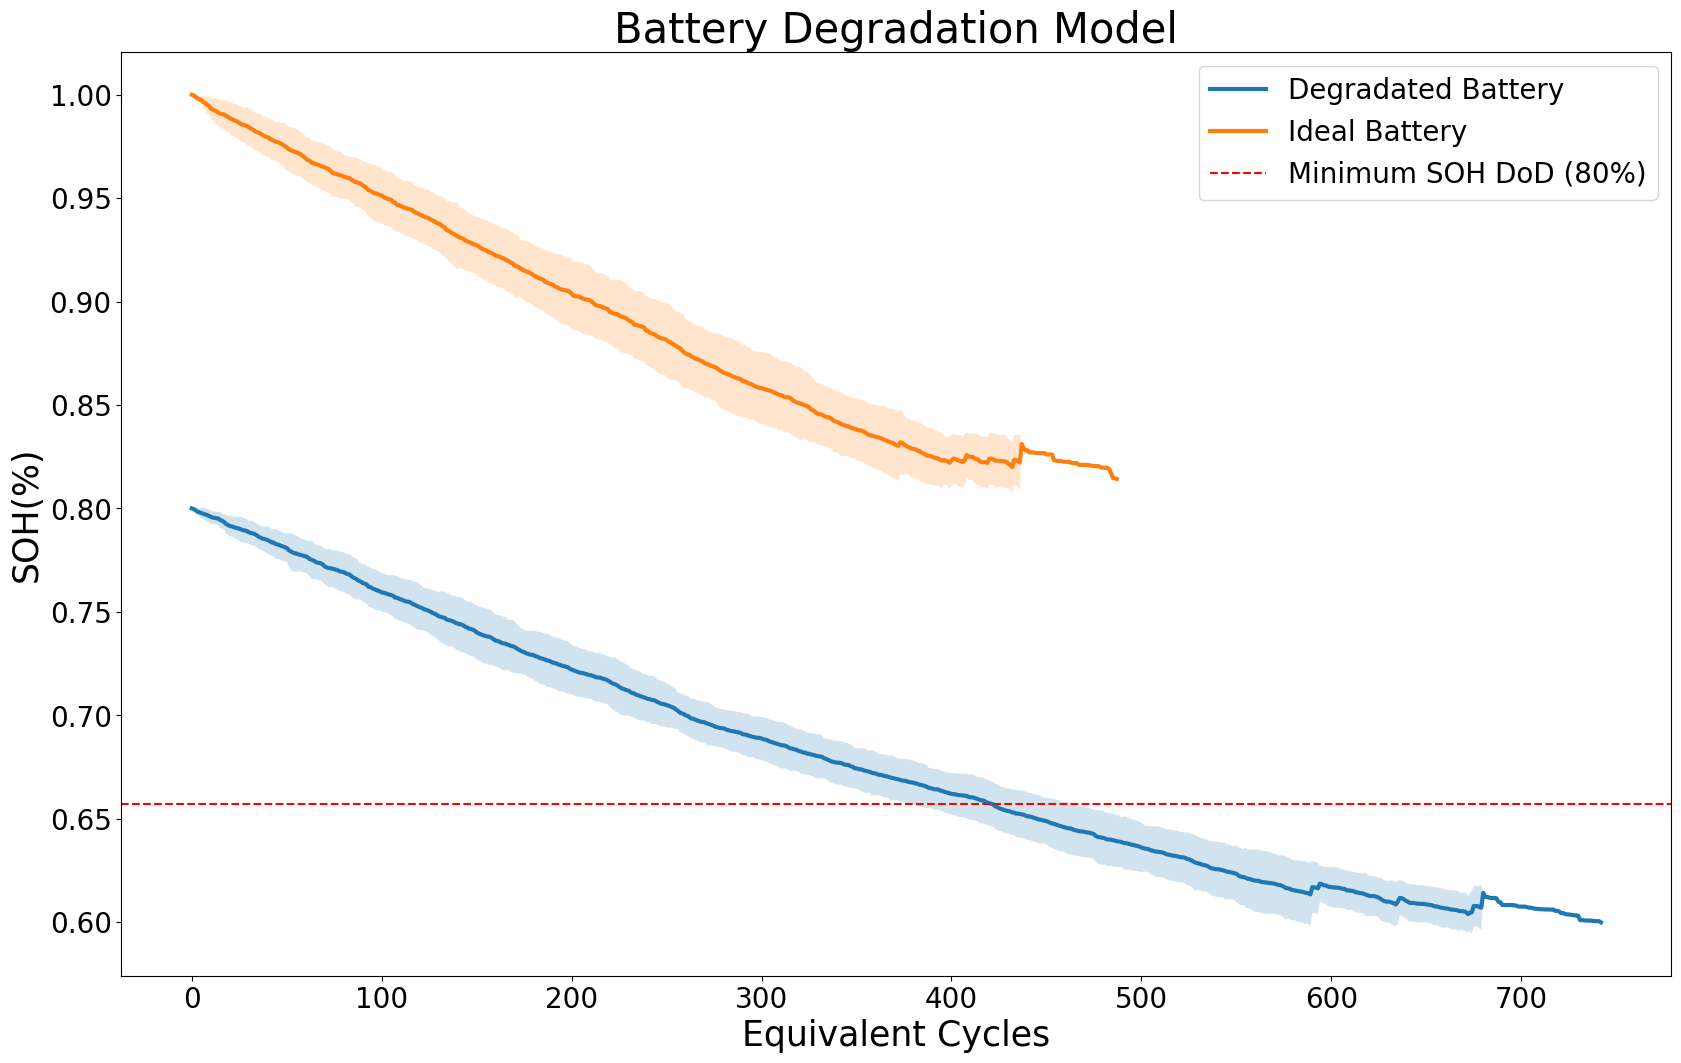

In [11]:
# ploteamos los resultados de las baterías degradadas e ideales
plt.figure(figsize=(20, 12))
plt.plot(mean_soh_degradated, label='Degradated Battery', linewidth=3)
plt.fill_between(
    np.arange(len(mean_soh_degradated)),
    mean_soh_degradated - 1.5 * std_soh_degradated,
    mean_soh_degradated + 1.5 * std_soh_degradated,
    alpha=0.2
)
plt.plot(mean_soh_ideal, label='Ideal Battery', linewidth=3)
plt.fill_between(
    np.arange(len(mean_soh_ideal)),
    mean_soh_ideal - 1.5 * std_soh_ideal,
    mean_soh_ideal + 1.5 * std_soh_ideal,
    alpha=0.2
)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title("Battery Degradation Model", fontsize=30)
plt.xlabel("Equivalent Cycles", fontsize=25)
plt.ylabel("SOH(%)", fontsize=25)

# add a horizontal line at 0.6
plt.axhline(y=0.657, color='r', linestyle='--', label='Minimum SOH DoD (80%)')
plt.legend(fontsize=20)
plt.show()


In [8]:
# print the total cycles for each battery
print(f"ciclo equivalntes totales para la batería degradada: {total_cycles_degradated:.2f}")
print(f"ciclo equivalntes totales para la batería ideal: {total_cycles_ideal:.2f}")

ciclo equivalntes totales para la batería degradada: 648.00
ciclo equivalntes totales para la batería ideal: 415.30


In [9]:
# ejemplo de valorización de la batería degradada
SOH_actual_prop = deg_initial_SOH
cap_0_prop = degradated_batt.parameters["Qmax"]
min_cap_app = aplication_cap
valor_ideal = 5.2  # Ideal value of the battery in monetary units
prop_cycles = total_cycles_degradated
ideal_cycles = total_cycles_ideal
# Calculamos el valor de la batería degradada
valor_deg_id = valorización(SOH_actual_prop, cap_0_prop, min_cap_app, valor_ideal, prop_cycles, ideal_cycles)
print(f"Valor económico de la batería ideal: {valor_ideal:.2f} monetary units")
print(f"Valor económico de la batería degradada (usando precio de batería ideal): {valor_deg_id:.2f} monetary units")

valor_ideal = 6
valor_deg_deg = valorización(SOH_actual_prop, cap_0_prop, min_cap_app, valor_ideal, prop_cycles, ideal_cycles)
print(f"Valor económico de la batería degradada cuando nueva: {valor_ideal:.2f} monetary units")
print(f"Valor económico de la batería degradada (usando precio de batería degradada cuando es nueva): {valor_deg_deg:.2f} monetary units")

Valor económico de la batería ideal: 5.20 monetary units
Valor económico de la batería degradada (usando precio de batería ideal): 4.06 monetary units
Valor económico de la batería degradada cuando nueva: 6.00 monetary units
Valor económico de la batería degradada (usando precio de batería degradada cuando es nueva): 4.68 monetary units


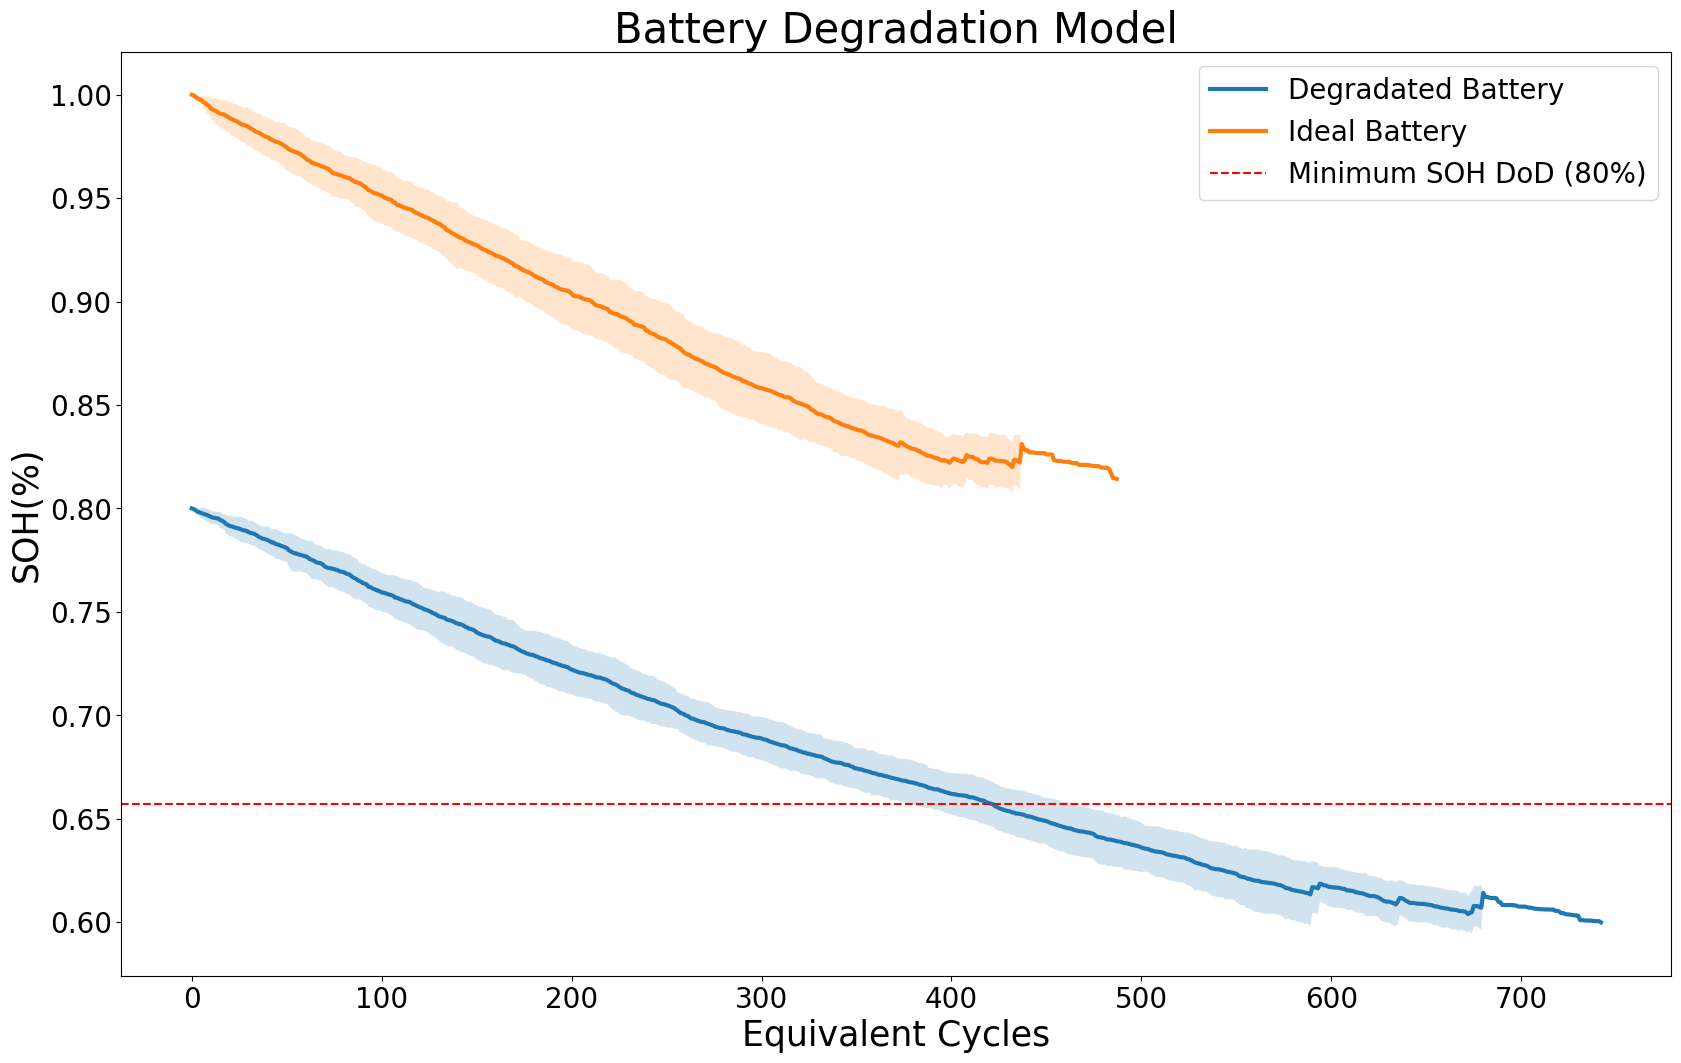

In [ ]:
# ploteamos los resultados de las baterías degradadas e ideales
plt.figure(figsize=(20, 12))
plt.plot(mean_soh_degradated, label='Degradated Battery', linewidth=3)
plt.fill_between(
    np.arange(len(mean_soh_degradated)),
    mean_soh_degradated - 1.5 * std_soh_degradated,
    mean_soh_degradated + 1.5 * std_soh_degradated,
    alpha=0.2
)
plt.plot(mean_soh_ideal, label='Ideal Battery', linewidth=3)
plt.fill_between(
    np.arange(len(mean_soh_ideal)),
    mean_soh_ideal - 1.5 * std_soh_ideal,
    mean_soh_ideal + 1.5 * std_soh_ideal,
    alpha=0.2
)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title("Battery Degradation Model", fontsize=30)
plt.xlabel("Equivalent Cycles", fontsize=25)
plt.ylabel("SOH(%)", fontsize=25)

# add a horizontal line at 0.6
plt.axhline(y=0.657, color='r', linestyle='--', label='Minimum SOH DoD (80%)')
plt.legend(fontsize=20)
plt.show()


In [10]:
# cálculo de costo por ciclo equivalente de la batería degradada
costo_por_ciclo_degradated = valor_deg_id / total_cycles_degradated
print(f"Costo por ciclo de la batería degradada (usando precio de batería ideal): {costo_por_ciclo_degradated:.5f} monetary units")
costo_por_ciclo_degradated_deg = valor_deg_deg / total_cycles_degradated
print(f"Costo por ciclo de la batería degradada (usando precio de batería degradada nueva): {costo_por_ciclo_degradated_deg:.5f} monetary units")

# cálculo de costo por ciclo equivalente de la batería ideal
costo_por_ciclo_ideal = valor_ideal / total_cycles_ideal
print(f"Costo por ciclo de la batería ideal: {costo_por_ciclo_ideal:.5f} monetary units")

Costo por ciclo de la batería degradada (usando precio de batería ideal): 0.00626 monetary units
Costo por ciclo de la batería degradada (usando precio de batería degradada nueva): 0.00722 monetary units
Costo por ciclo de la batería ideal: 0.01445 monetary units
